### Load the datasets into memory
There are better ways to do this, but since the datasets are small enough, we can keep it simple.

In [1]:
MEAN_PIXEL_VALUE = 128
PIXEL_STANDARD_DEVIATION = 80
SEGMENT_SIZE = 128

In [2]:
import numpy as np

def preprocess_image(image):
    """Converts the given image to grayscale, subtracts the mean*, and divides by the standard deviation*.
    
    * (roughly)
    
    The returned np.array uses 16-bit floats to conserve memory.
    """
    
    global MEAN_PIXEL_VALUE
    global PIXEL_STANDARD_DEVIATION
    
    image = image.convert('L')
    image = np.array(image).astype(np.float16)
    image = image - MEAN_PIXEL_VALUE
    image = image / PIXEL_STANDARD_DEVIATION
    
    return image

In [3]:
from os import walk
from PIL import Image

def load_images(dir_path, n_max=-1):
    """
    """
    images = []
    
    for filename in next(walk(dir_path))[2]:
        if len(images) == n_max:
            break
        
        images.append(preprocess_image(Image.open(dir_path + filename)))
        
    return images

In [4]:
training_images = []
training_labels = []

training_images.extend(load_images('../data/train/no-text/'))
n_no_text = len(training_images)
training_labels.extend([[1, 0] for i in range(n_no_text)])

training_images.extend(load_images('../data/train/text/'))
n_text = len(training_images) - n_no_text
training_labels.extend([[0, 1] for i in range(n_text)])

training_images = np.array(training_images)
training_labels = np.array(training_labels)

In [5]:
validation_images = []
validation_labels = []

validation_images.extend(load_images('../data/valid/no-text/'))
n_no_text = len(validation_images)
validation_labels.extend([[1, 0] for i in range(n_no_text)])

validation_images.extend(load_images('../data/valid/text/'))
n_text = len(validation_images) - n_no_text
validation_labels.extend([[0, 1] for i in range(n_text)])

validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

### Train model

In [6]:
def get_batch(batch_size, use_training_set=True):
    """
    """
    
    if use_training_set:
        indexes = np.random.choice(np.arange(len(training_images)), batch_size, False)
        images = training_images[indexes]
        labels = training_labels[indexes]
    else:
        indexes = np.random.choice(np.arange(len(validation_images)), batch_size, False)
        images = validation_images[indexes]
        labels = validation_labels[indexes]
        
    return images, labels

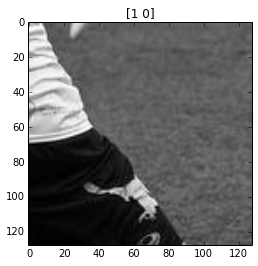

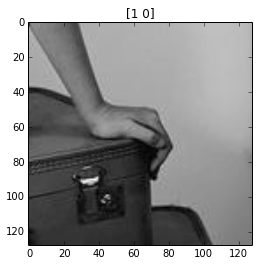

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

def fill_feed_dict(pl_images, pl_labels, pl_learning_rate, pl_keep_prob, batch_size, learning_rate, keep_prob):
    """
    """
    
    global SEGMENT_SIZE
    
    training = learning_rate != 0
    images, labels = get_batch(batch_size, training)
    
    images = np.reshape(images, (batch_size, SEGMENT_SIZE, SEGMENT_SIZE, 1))
    labels = np.reshape(labels, (batch_size, 2))
    
    feed_dict = {
        pl_images: images,
        pl_labels: labels,
        pl_learning_rate: learning_rate,
        #pl_keep_prob: keep_prob # Disabled so that the graph can run on Android
    }
    
    return feed_dict


test_feed_dict = fill_feed_dict('images', 'labels', 'learning_rate', 'keep_prob', 2, 0.01, 1.0)

for i in range(len(test_feed_dict['images'])):
    plt.figure()
    plt.title(str(test_feed_dict['labels'][i]))
    plt.imshow(test_feed_dict['images'][i].squeeze(), cmap=plt.cm.gray)

In [1]:
import tensorflow as tf

WEIGHT_PENALTY_RATE = 3e-3


def weight_variable(shape, stddev):
    global WEIGHT_PENALTY_RATE
    
    initial = tf.truncated_normal(shape, stddev=stddev)
    weights = tf.Variable(initial)
    
    tf.add_to_collection('losses', tf.mul(tf.nn.l2_loss(weights), WEIGHT_PENALTY_RATE))
    
    return weights

def bias_variable(shape, init):
    global WEIGHT_PENALTY_RATE
    
    initial = tf.constant(init, shape=shape)
    biases = tf.Variable(initial)
    
    tf.add_to_collection('losses', tf.mul(tf.nn.l2_loss(biases), WEIGHT_PENALTY_RATE))
    
    return biases

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(3)<module>()

ipdb> help

Documented commands (type help <topic>):
EOF    cl         disable  interact  pdef     quit     source     up    
a      clear      display  j         pdoc     r        step       w     
alias  commands   down     jump      pfile    restart  tbreak     whatis
args   condition  enable   ll        pinfo    return   u          where 
b      cont       exit     longlist  pinfo2   retval   unalias  
break  continue   h        n         pp       run      undisplay
bt     d          help     next      psource  rv       unt      
c      debug      ignore   p         q        s        until    

Miscellaneous help topics:
exec  pdb

Undocumented commands:
l  list

ipdb> c


In [23]:
# Make sure we don't count losses multiple times by resetting the graph
tf.reset_default_graph()


x = tf.placeholder(tf.float32, shape=[None, SEGMENT_SIZE, SEGMENT_SIZE, 1], name='input')
y_ = tf.placeholder(tf.float32, shape=[None, 2])

W_conv1 = weight_variable([5, 5, 1, 32], 1e-4)
b_conv1 = bias_variable([32], 0.1)
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)

h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64], 1e-4)
b_conv2 = bias_variable([64], 0.1)
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

h_pool2 = max_pool_2x2(h_conv2)

n = SEGMENT_SIZE // (2 ** 4)
W_fc1 = weight_variable([n * n * 64, 512], 0.04)
b_fc1 = bias_variable([512], 0.1)

h_pool2_flat = tf.reshape(h_pool2, [-1, n * n * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# For some reason the Android version of TF doesn't like dropout
#pl_keep_prob = tf.placeholder(tf.float32, name='keep_prob')
#h_fc1_drop = tf.nn.dropout(h_fc1, pl_keep_prob)
pl_keep_prob = 'foo'

W_fc2 = weight_variable([512, 2], 0.1)
b_fc2 = bias_variable([2], 0.1)

y_conv = tf.nn.softmax(tf.matmul(h_fc1, W_fc2) + b_fc2, name='output')


cross_entropy_mean = -tf.reduce_mean(y_ * tf.log(tf.clip_by_value(y_conv, 1e-10, 1)))
tf.add_to_collection('losses', cross_entropy_mean)

In [24]:
loss = tf.add_n(tf.get_collection('losses'))

pl_learning_rate = tf.placeholder(tf.float32, shape=[])

train_step = tf.train.MomentumOptimizer(pl_learning_rate, momentum=0.9).minimize(loss)

In [25]:
correct_prediction = tf.equal(tf.arg_max(y_conv, 1), tf.arg_max(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [33]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.initialize_all_variables())

test_interval = 600
test_iters = 300
display_interval = 50
n_iters = test_interval * 60

learning_rate = 0.003
step_size = test_interval * 30
lr_step_rate = 0.3
batch_size = 100

all_validation_accuracies = []
all_validation_losses = []
all_training_losses = []

for i in range(n_iters):
    if i % test_interval == 0:
        validation_accuracies = []
        validation_losses = []
        
        for j in range(test_iters):
            feed_dict = fill_feed_dict(x, y_, pl_learning_rate, pl_keep_prob, batch_size, 0, 1)
            validation_accuracy, validation_loss = sess.run([accuracy, loss], feed_dict=feed_dict)
        
            validation_accuracies.append(validation_accuracy)
            validation_losses.append(validation_loss)
        
        mean_validation_accuracy = np.mean(validation_accuracies)
        mean_validation_loss = np.mean(validation_losses)
        
        print('Validation accuracy: ' + str(mean_validation_accuracy))
        print('Validation loss: ' + str(mean_validation_loss))
        
        all_validation_accuracies.append(mean_validation_accuracy)
        all_validation_losses.append(mean_validation_loss)
        
    feed_dict = fill_feed_dict(x, y_, pl_learning_rate, pl_keep_prob, batch_size, learning_rate, 0.5)
    _, training_loss = sess.run([train_step, loss], feed_dict=feed_dict)
    
    if i % display_interval == 0:
        print('Training loss: ' + str(training_loss))
        print('========')
        
        all_training_losses.append(training_loss)
        
    if i % step_size == 0 and i != 0:
        learning_rate = learning_rate * lr_step_rate
        print('Updated learning rate: ' + str(learning_rate))
        print('========')

Validation accuracy: 0.6708
Validation loss: 4.23605
Training loss: 4.28918
Training loss: 4.2365
Training loss: 4.20022
Training loss: 4.1624
Training loss: 4.1398
Training loss: 4.09775
Training loss: 4.06924
Training loss: 4.02911
Training loss: 4.00016
Training loss: 3.96245
Training loss: 3.92713
Training loss: 3.89194
Validation accuracy: 0.467067
Validation loss: 3.88401
Training loss: 3.87114
Training loss: 3.82746
Training loss: 3.79509
Training loss: 3.75617
Training loss: 3.73484
Training loss: 3.70285
Training loss: 3.70107
Training loss: 3.63837
Training loss: 3.60278
Training loss: 3.56234
Training loss: 3.54588
Training loss: 3.51245
Validation accuracy: 0.6124
Validation loss: 3.48921
Training loss: 3.48455
Training loss: 3.47477
Training loss: 3.44638
Training loss: 3.39604
Training loss: 3.37563
Training loss: 3.3579
Training loss: 3.36465
Training loss: 3.31067
Training loss: 3.25229
Training loss: 3.2209
Training loss: 3.2036
Training loss: 3.19648
Validation accura

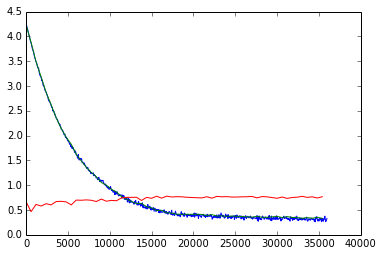

In [34]:
from matplotlib import pyplot as plt

completed_iters = display_interval * len(all_training_losses)

ind_training = range(0, completed_iters, display_interval)
plt.plot(ind_training, all_training_losses)

ind_validation = range(0, completed_iters, test_interval)
plt.plot(ind_validation, all_validation_losses)
plt.plot(ind_validation, all_validation_accuracies)

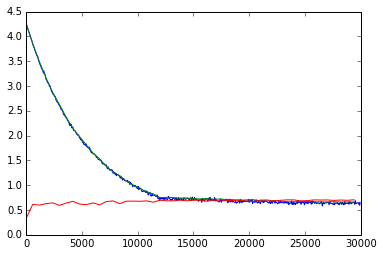

In [32]:
from matplotlib import pyplot as plt

completed_iters = display_interval * len(all_training_losses)

ind_training = range(0, completed_iters, display_interval)
plt.plot(ind_training, all_training_losses)

ind_validation = range(0, completed_iters, test_interval)
plt.plot(ind_validation, all_validation_losses)
plt.plot(ind_validation, all_validation_accuracies)

### Save and freeze the created graph

In [28]:
saver = tf.train.Saver()
saver.save(sess, './saved_checkpoint', 0, 'checkpoint_state')

tf.train.write_graph(sess.graph.as_graph_def(), '.', 'input_graph.pb')

In [29]:
from freeze_graph import freeze_graph

freeze_graph('./input_graph.pb', '', False, './saved_checkpoint-0',
             'output', 'save/restore_all',
             'save/Const:0', '../second-sight/assets/tensorflow_text_detector.pb',
             False, None)

Converted 8 variables to const ops.
33 ops in the final graph.


In [13]:
%%bash

cd ..

bazel mobile-install //second-sight:second-sight --start_app

Updating 1 dex...
Application resources up-to-date
Updating 0 native libs...
Starting application com.martinbede.secondsight


____Loading...
____Found 1 target...
____[4 / 8] Generating incremental apk
____[7 / 8] Still waiting for 1 job to complete:
      Running (standalone):
        Installing //second-sight:second-sight, 10 s
____From Installing //second-sight:second-sight:
Target //second-sight:second-sight up-to-date:
  bazel-bin/second-sight/second-sight_files/full_deploy_marker
____Elapsed time: 18.820s, Critical Path: 18.68s
